In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_scatter import scatter_add

CUDA: True cuda:0


In [9]:
!pip install tensorboardX

   ---------------------------------------- 0.0/101.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/101.7 kB ? eta -:--:--
   ------------------------ --------------- 61.4/101.7 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 101.7/101.7 kB 1.5 MB/s eta 0:00:00


In [13]:
!pip install torch_geometric

     ---------------------------------------- 0.0/64.2 kB ? eta -:--:--
     ------------ ------------------------- 20.5/64.2 kB 640.0 kB/s eta 0:00:01
     ------------------------ ------------- 41.0/64.2 kB 487.6 kB/s eta 0:00:01
     -------------------------------------- 64.2/64.2 kB 573.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ----------- ---------------------------- 0.3/1.1 MB 6.3 MB/s eta 0:00:01
   ------------------------------- -------- 0.9/1.1 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 10.0 MB/s eta 0:00:00


In [17]:
!pip install torch_scatter 

     ---------------------------------------- 0.0/108.0 kB ? eta -:--:--
     ------- ----------------------------- 20.5/108.0 kB 640.0 kB/s eta 0:00:01
     ------------------------------------ - 102.4/108.0 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 108.0/108.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp312-cp312-win_amd64.whl size=336482 sha256=0f469a3af20102ffea5aadeaac9ae3df67abe162e252d40572325e11e3828f53
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\84\20\50\44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch_scatter


### Converting the collected Data in numpy to Tensor

In [3]:
def load_graphdata_channel1(batch_size,shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    #file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    #filename = os.path.join('../input/processing-traffic-data-for-deep-learning-projects/', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    #print('load file:', filename)

    file_data = np.load(r"C:\Users\User\Traffic_Flow_Forecasting\ASTGCN_Baseline_Model\PEMS04_Preprocessing\PEMS04_r1_d0_w0_astcgn.npz")
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std

In [5]:
batch_size = 64

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(batch_size)

train: torch.Size([10181, 307, 1, 12]) torch.Size([10181, 307, 12])
val: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])
test: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])


In [7]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        #------------ Ignore
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

In [9]:
id_filename = None
adj_filename = r'C:\Users\User\Traffic_Flow_Forecasting\ASTGCN_Baseline_Model\PEMS04\PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename)

In [11]:
rows, cols = np.where(adj_mx == 1)

In [13]:
edges = zip(rows.tolist(), cols.tolist())

In [15]:
for i, edge in enumerate(edges):
    print(f"Edge {i+1}: {edge}")

Edge 1: (0, 92)
Edge 2: (1, 46)
Edge 3: (1, 119)
Edge 4: (1, 252)
Edge 5: (2, 81)
Edge 6: (3, 230)
Edge 7: (3, 231)
Edge 8: (3, 247)
Edge 9: (4, 246)
Edge 10: (5, 154)
Edge 11: (6, 83)
Edge 12: (8, 300)
Edge 13: (9, 239)
Edge 14: (10, 9)
Edge 15: (11, 230)
Edge 16: (12, 41)
Edge 17: (13, 26)
Edge 18: (14, 89)
Edge 19: (15, 8)
Edge 20: (16, 40)
Edge 21: (17, 63)
Edge 22: (18, 43)
Edge 23: (19, 162)
Edge 24: (19, 266)
Edge 25: (21, 233)
Edge 26: (22, 49)
Edge 27: (23, 22)
Edge 28: (25, 178)
Edge 29: (26, 94)
Edge 30: (27, 46)
Edge 31: (27, 98)
Edge 32: (27, 216)
Edge 33: (28, 57)
Edge 34: (29, 222)
Edge 35: (30, 67)
Edge 36: (31, 215)
Edge 37: (32, 10)
Edge 38: (33, 181)
Edge 39: (34, 161)
Edge 40: (35, 54)
Edge 41: (35, 115)
Edge 42: (35, 265)
Edge 43: (36, 78)
Edge 44: (37, 84)
Edge 45: (38, 65)
Edge 46: (39, 234)
Edge 47: (40, 105)
Edge 48: (41, 272)
Edge 49: (42, 58)
Edge 50: (43, 118)
Edge 51: (44, 7)
Edge 52: (45, 12)
Edge 53: (46, 31)
Edge 54: (46, 216)
Edge 55: (47, 35)
Edge 56: 

In [49]:
!pip install sns

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2645 sha256=cd2f5b87cd1482697225b319c97619f2b385c4a2fafbf7ee17f13d7ec7c4ce50
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\26\ac\4b\7743e50a108f4a12a07e0e257dbecefc884a953125a6e1b48f
Successfully built sns


In [17]:
import seaborn as sns

In [61]:
pip install --upgrade seaborn

Note: you may need to restart the kernel to use updated packages.


In [19]:
print(distance_mx.shape)
print(np.min(distance_mx), np.max(distance_mx))
print(np.sum(distance_mx))

(307, 307)
0.0 2712.1
139502.2


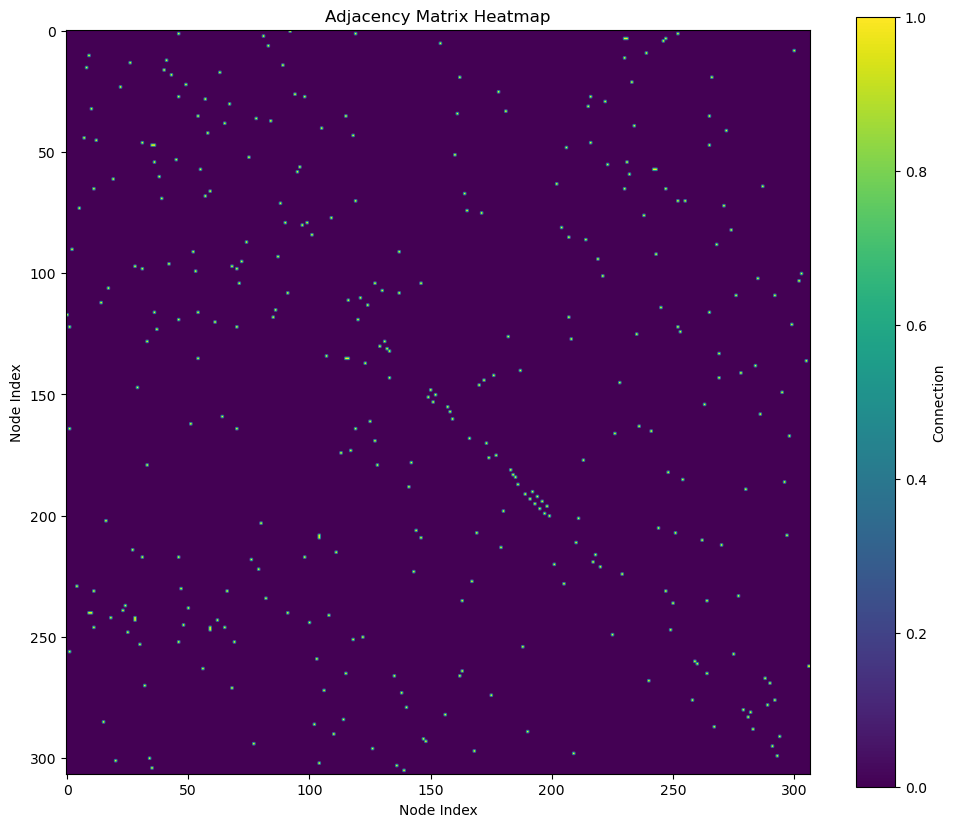

In [21]:
plt.figure(figsize=(12, 10))
plt.imshow(adj_mx, cmap='viridis')
plt.colorbar(label='Connection')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

#### Converting the Edge Data to Tensor

In [28]:
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

In [30]:
edge_index_data

tensor([[  0,   1,   2,  ..., 880, 881, 882],
        [475, 179,   0,  ..., 108,  46, 788]], device='cuda:0')